## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [7]:
raw_data = yfinance.download(tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                            auto_adjust = True, threads = True)

[*********************100%***********************]  3 of 3 completed


In [8]:
df = raw_data.copy()

## Defining Key Dates

In [9]:
# Starting Date
start_date = "2009-04-05"

# First Official Announcement - 49.9%
ann_1 = "2009-12-09"

# Second Official Announcement - 51.1%
ann_2 = "2012-07-05" 

#Ending Date
end_date = "2014-01-01"

# Dieselgate
d_gate = "2015-09-20"

## Pre-processing the Data

In [12]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [13]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method = 'bfill')

In [14]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

## Plotting the Prices

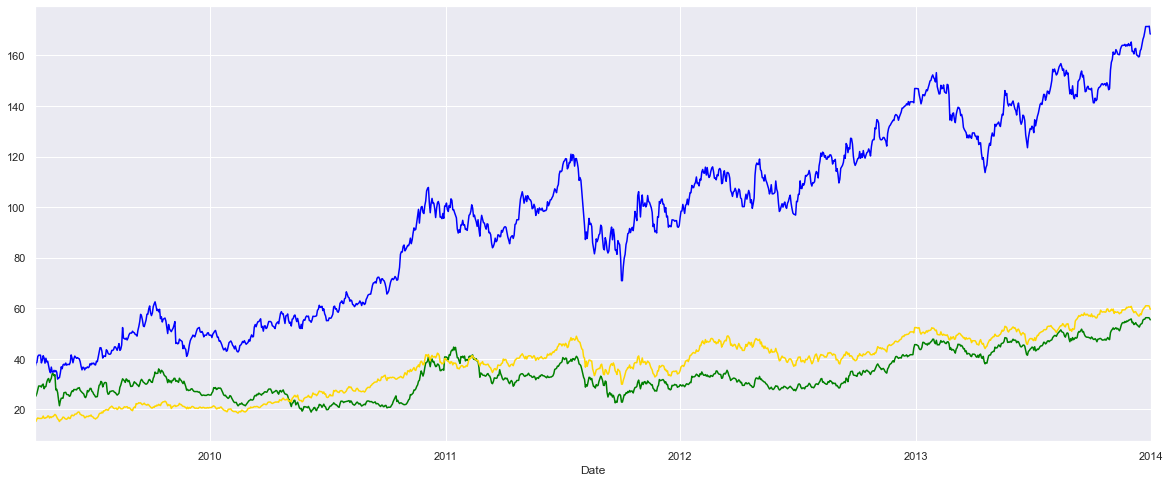

In [15]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color="blue")
df['por'][start_date:end_date].plot(color="green")
df['bmw'][start_date:end_date].plot(color="gold")
plt.show()

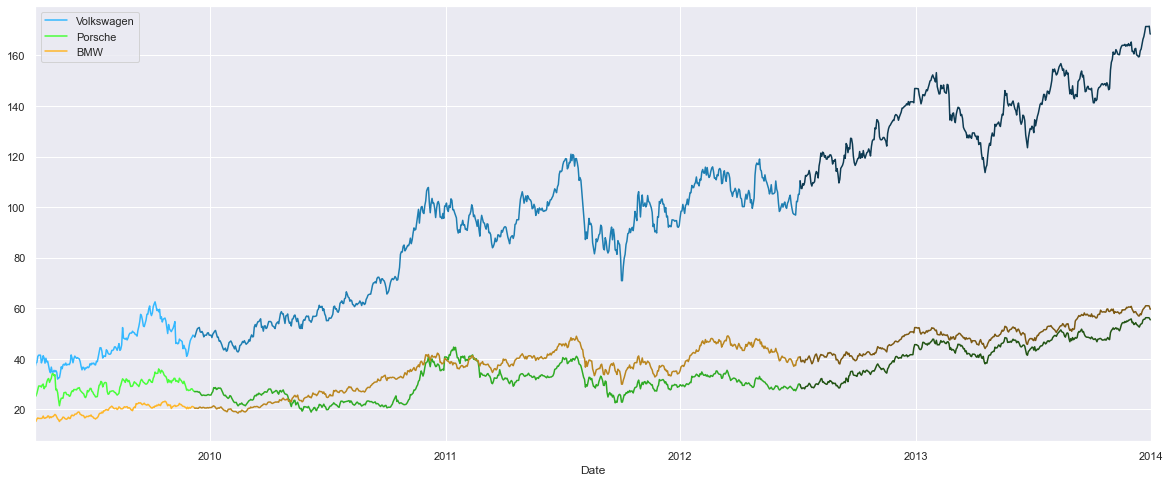

In [18]:
#color = "#33B8FF"
df['vol'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
#color = "#49FF3A"
df['por'][start_date:ann_1].plot(color="#49FF3A")
#color = "#FEB628"
df['bmw'][start_date:ann_1].plot(color="#FEB628")

#color = "#1E7EB2"
df['vol'][ann_1:ann_2].plot(color="#1E7EB2")
#color = "#2FAB25"
df['por'][ann_1:ann_2].plot(color="#2FAB25")
#color = "#BA861F"
df['bmw'][ann_1:ann_2].plot(color="#BA861F")

#color = "#0E3A52"
df['vol'][ann_2:end_date].plot(color = "#0E3A52")
#color = "#225414"
df['por'][ann_2:end_date].plot(color = "#225414")
#color = "#7C5913"
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen', 'Porsche', 'BMW'])
plt.show()

## Correlation

In [20]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359546996713387
Volkswagen and BMW correlation: 	0.9799378233744074
Porsche and BMW correlation: 		0.805215773083207


In [21]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633583301976247
Volkswagen and BMW correlation: 	0.8427607690256786
Porsche and BMW correlation: 		0.6095039090103118


In [22]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428268025913793
Volkswagen and BMW correlation: 	0.9795942961767461
Porsche and BMW correlation: 		0.7042723197642161


In [27]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1]) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2022-03-24 00:00:00

Volkswagen and Porsche correlation: 	0.9263840053804974
Volkswagen and BMW correlation: 	0.702243331249446
Porsche and BMW correlation: 		0.7702610267780152


In [28]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(d_gate) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][end_date:d_gate].corr(df['por'][end_date:d_gate])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))

Correlation among manufacturers from 2014-01-01 to 2015-09-20

Volkswagen and Porsche correlation: 	0.9421376109923439
Volkswagen and BMW correlation: 	0.891220780207344
Porsche and BMW correlation: 		0.8045872101146415


In [30]:
print('Correlation among manufacturers from ' + str(d_gate) + ' to ' + str(df.index[-1]) + "\n")
print('Volkswagen and Porsche correlation: \t' + str(df['vol'][d_gate:].corr(df['por'][d_gate:])))
print('Volkswagen and BMW correlation: \t' + str(df['vol'][d_gate:].corr(df['bmw'][d_gate:])))
print('Porsche and BMW correlation: \t\t' + str(df['por'][d_gate:].corr(df['bmw'][d_gate:])))

Correlation among manufacturers from 2015-09-20 to 2022-03-24 00:00:00

Volkswagen and Porsche correlation: 	0.961738359138887
Volkswagen and BMW correlation: 	0.7132796732965183
Porsche and BMW correlation: 		0.782376948868244


## Best Fitting Models

### For Volkswagen

In [31]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1], 
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por', 'bmw']][ann_1:ann_2],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por', 'bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [32]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -322.988
Date:                Thu, 24 Mar 2022   AIC                            655.976
Time:                        16:06:48   BIC                            671.885
Sample:                    04-06-2009   HQIC                           662.427
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7232      0.447      1.618      0.106      -0.153       1.599
por            0.4000      0.096      4.168      0.000       0.212       0.588
bmw            0.6919      0.328      2.107      0.035       0.048       1.335
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.1737      0.148     14.718      0.000       1.884       2.463
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1080.051
Date:                Thu, 24 Mar 2022   AIC                           2166.102
Time:                        16:07:16   BIC                           2179.629
Sample:                    12-09-2009   HQIC                          2171.341
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7908      0.062     12.842      0.000       0.670       0.912
bmw            1.5487      0.073     21.269      0.000       1.406       1.691
sigma2         1.4643      0.060     24.532      0.000       1.347       1.581
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -607.775
Date:                Thu, 24 Mar 2022   AIC                           1221.549
Time:                        16:07:19   BIC                           1233.440
Sample:                    07-05-2012   HQIC                          1226.263
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7190      0.057     30.369      0.000       1.608       1.830
bmw            0.8575      0.091      9.381      0.000       0.678       1.037
sigma2         1.3324      0.065     20.461      0.000       1.205       1.460
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [35]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol', 'bmw']][start_date:ann_1], 
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol', 'bmw']][ann_1:ann_2],
                           m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol', 'bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [36]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -225.800
Date:                Thu, 24 Mar 2022   AIC                            463.601
Time:                        16:12:10   BIC                            482.691
Sample:                    04-06-2009   HQIC                           471.343
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5755      0.375      1.533      0.125      -0.160       1.311
vol            0.1150      0.053      2.157      0.031       0.011       0.219
bmw            0.8819      0.159      5.558      0.000       0.571       1.193
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7319      0.052     14.098      0.000       0.630       0.834
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -580.934
Date:                Thu, 24 Mar 2022   AIC                           1171.867
Time:                        16:12:15   BIC                           1194.411
Sample:                    12-09-2009   HQIC                          1180.599
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1785      0.016     11.134      0.000       0.147       0.210
bmw            0.3317      0.046      7.200      0.000       0.241       0.422
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3308      0.010     32.415      0.000       0.311       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.52
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -210.239
Date:                             Thu, 24 Mar 2022   AIC                            428.478
Time:                                     16:12:19   BIC                            444.333
Sample:                                 07-05-2012   HQIC                           434.764
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2219      0.013     16.876      0.000       0.196       0.248
bmw            0.2504      0.041      6.037      0.000       0.169       0.332
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1725      0.006     27.851      0.000       0.160       0.185
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.60
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

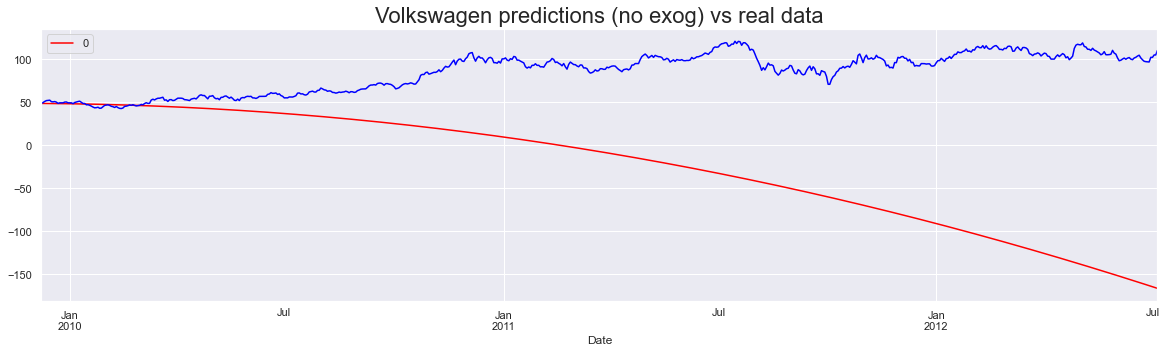

In [39]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen predictions (no exog) vs real data", size = 22)
plt.show()

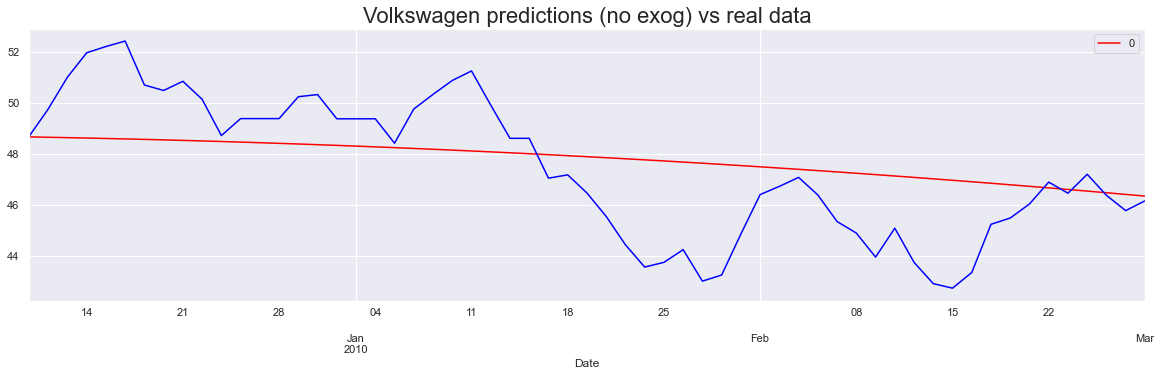

In [40]:
df_auto_pred_pr[ann_1:"2010-03-01"].plot(figsize = (20,5), color = "red")
df.vol[ann_1:"2010-03-01"].plot(color="blue")
plt.title("Volkswagen predictions (no exog) vs real data", size = 22)
plt.show()

### For Volkswagen

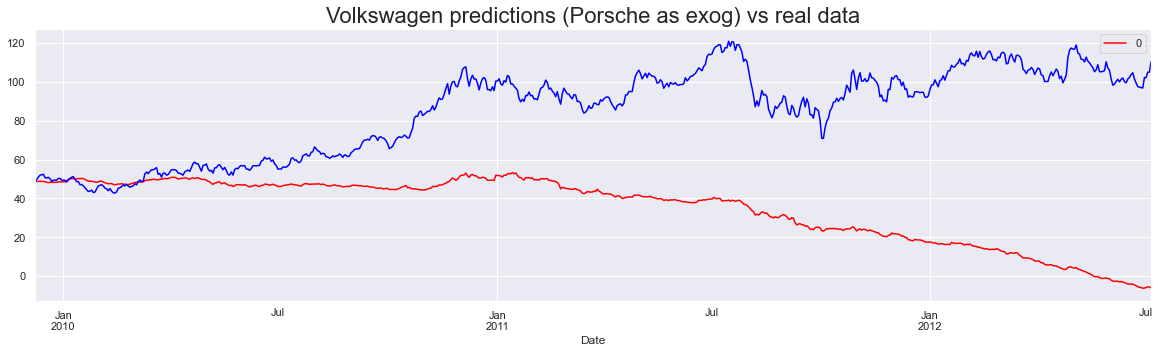

In [43]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), 
                                                          exogenous = df[['por']][ann_1:ann_2]), 
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen predictions (Porsche as exog) vs real data", size = 22)
plt.show()

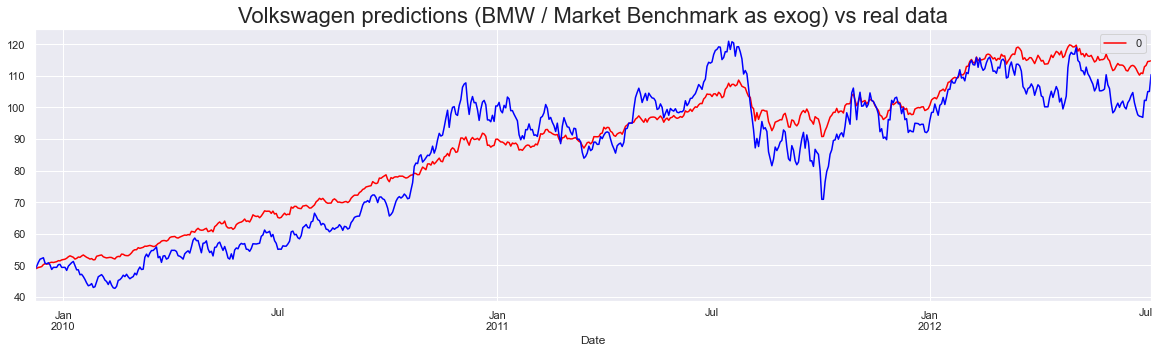

In [45]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), 
                                                          exogenous = df[['bmw']][ann_1:ann_2]), 
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen predictions (BMW / Market Benchmark as exog) vs real data", size = 22)
plt.show()

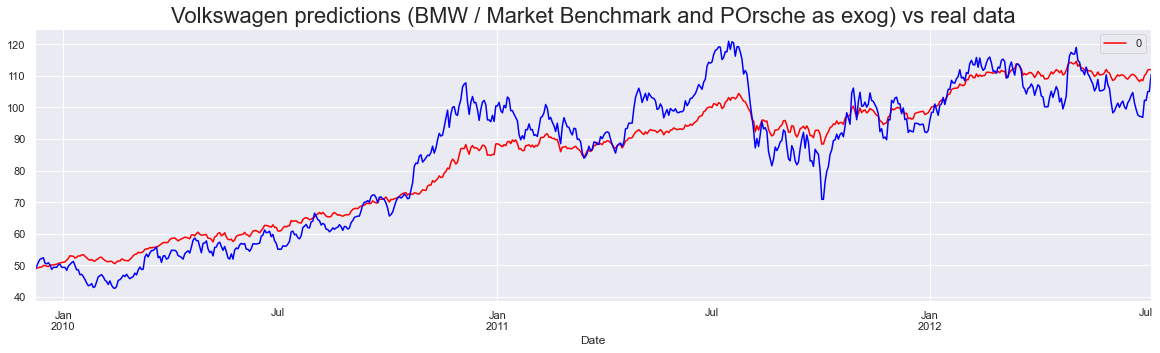

In [47]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw', 'por']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), 
                                                          exogenous = df[['bmw', 'por']][ann_1:ann_2]), 
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color="blue")
plt.title("Volkswagen predictions (BMW / Market Benchmark and POrsche as exog) vs real data", size = 22)
plt.show()

## Volatility

### Volatility of VW for Each Period

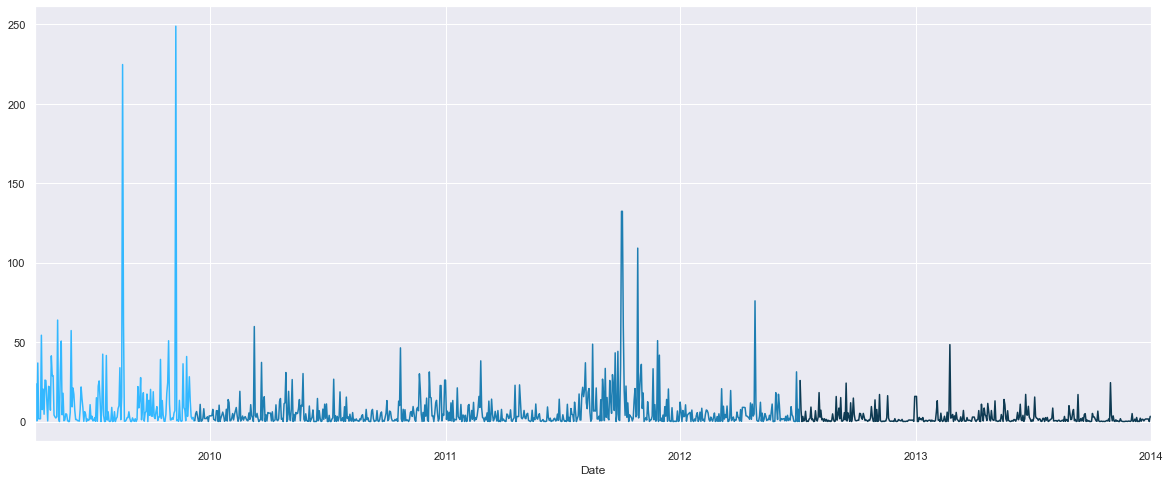

In [48]:
df['sq_vol'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color="#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for Each Period

In [49]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7774836648621
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.0031157094181
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9904602742612
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9904602219715
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.753486410742
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7315554390202
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7315554377756
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5623774021709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5580417942172
            Iterations: 7
            Fu

In [50]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Thu, Mar 24 2022   Df Residuals:                      177
Time:                        16:39:55   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    6.8426e-13      0.349  1.959e-12      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [51]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Thu, Mar 24 2022   Df Residuals:                      671
Time:                        16:39:55   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [52]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Thu, Mar 24 2022   Df Residuals:                      389
Time:                        16:39:55   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.990e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""